In [1]:
import pandas as pd
import numpy as np
import os
import re


This section of code collects and matches all csv

In [2]:
# Config Settings
time_before = 600
time_after = 600
bout_size_in_frames = 300
dst_dir = "/home/thomas/RatAnalysis/RatClustering/Footshock_Session1_Fixed"

In [3]:
# Collects CSVs
folders = [os.path.join(dst_dir, d) for d in os.listdir(dst_dir) if os.path.isdir(os.path.join(dst_dir, d))]
file_matches = []

for folder in folders:
    Bottom_Camera = ""
    Pose_Data = ""
    Shock_Off_Set = ""
    Shock_On_Set = ""
    Side_View = ""
    Tone_Off_Set = ""
    Tone_On_Set = ""
    Void_Timing = ""
    for filename in os.listdir(folder):
        match = re.search(r'Ai213_\d+-\d+_#\d+', filename)

        filename = os.path.join(folder,filename)
        if "Bottom_camera" in filename:
            Bottom_Camera = filename
        if "Pose_Data" in filename:
            Pose_Data = filename
        if "ShockOffset" in filename:
            Shock_Off_Set = filename
        if "ShockONset" in filename:
            Shock_On_Set = filename
        if "Side_view" in filename:
            Side_View = filename
        if "ToneOffset" in filename:
            Tone_Off_Set = filename
        if "ToneONset" in filename:
            Tone_On_Set = filename
        if "VoidTiming" in filename:
            Void_Timing = filename

    file_matches.append({
                "Filename" : match.group(0),
                "Bottom_Camera" : pd.read_csv(Bottom_Camera),
                "Pose_Data" : pd.read_csv(Pose_Data),
                "Shock_Off_Set" : pd.read_csv(Shock_Off_Set),
                "Shock_On_Set" : pd.read_csv(Shock_On_Set),
                "Side_View" : pd.read_csv(Side_View),
                "Tone_Off_Set" : pd.read_csv(Tone_Off_Set),
                "Tone_On_Set" : pd.read_csv(Tone_On_Set),
                "Void_Timing" : pd.read_csv(Void_Timing)})

AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
# Finds the bouts were the mouse voids
for group in file_matches:
    group["Pose_Data"]["Seconds"] = group["Side_View"]["Seconds"]
    df = group["Pose_Data"]
    df['Is_Voiding'] = False 

    for voidtime in group["Void_Timing"]["seconds"]:
        df['difference'] = (df['Seconds'] - voidtime).abs()

        closest_index = df['difference'].idxmin()

        df.loc[closest_index, 'Is_Voiding'] = True

    group["Pose_Data"] = df


In [ ]:
# Finds when tones start and end, and when clips begin and end
for group in file_matches:
    df = group["Pose_Data"]
    df['Tone_Start'] = False
    df['Tone_End'] = False
    df['Clip_Start'] = False
    df['Clip_End'] = False
    df['Keep'] = False

    df2 = pd.DataFrame(columns=df.columns)

    for tone_on, tone_off in zip(group["Tone_On_Set"]["side_Tone_frame"],group["Tone_Off_Set"]["side_Tone_frame"]):

        bout_fit = bout_size_in_frames - (((tone_off - tone_on) + time_before + time_after) % bout_size_in_frames)
        df.loc[tone_on, 'Tone_Start'] = True
        df.loc[tone_off, 'Tone_End'] = True
        df.loc[tone_on-time_before, 'Clip_Start'] = True
        df.loc[tone_off+time_after + bout_fit, 'Clip_End'] = True

        df.loc[tone_on-time_before + 1: tone_off+time_after + bout_fit, 'Keep'] = True

        if df2.empty:
            df2 = df[tone_on-time_before: tone_off+time_after + bout_fit].copy()
        else: 
            df2 = pd.concat([df2,df[tone_on-time_before: tone_off+time_after + bout_fit]], ignore_index=True) 
    group["Cliped_Pose_Data"] = group["Pose_Data"][~group["Pose_Data"]['Unnamed: 0'].isin(df2['Unnamed: 0'])]
    group["Pose_Data"] = df2

In [ ]:
def filter_out_batches_with_gaps(df):
    batch_size = 300

    df = df.sort_index()

    # Initialize an empty list to store valid batches
    valid_batches = []

    # Temporary list to hold the current batch of indices
    current_batch = []

    # Iterate over the dataframe indices
    for idx in df.index:
        if not current_batch:
            current_batch.append(idx)
        else:
            # Check if the current index is consecutive with the last index in the batch
            if idx == current_batch[-1] + 1:
                current_batch.append(idx)
            else:
                # If the batch reaches 300 consecutive indices, save it
                if len(current_batch) == batch_size:
                    valid_batches.append(df.loc[current_batch])
                # Reset the batch
                current_batch = [idx]
        
        # Save the last batch if it reaches 300 consecutive indices
        if len(current_batch) == batch_size:
            valid_batches.append(df.loc[current_batch])
            current_batch = []

    # Concatenate the valid batches into a single dataframe
    filtered_df = pd.concat(valid_batches, ignore_index=False)

    return filtered_df

In [ ]:
for group in file_matches:
    df = group["Cliped_Pose_Data"]
    df = filter_out_batches_with_gaps(df)
    group["Cliped_Pose_Data"] = df

In [ ]:
# This section does body normalization, x/y values - x/y.mean, based on the data in the rows
for group in file_matches:
    df = group["Pose_Data"].copy()

    x_cols = df.filter(regex='_x$').columns
    y_cols = df.filter(regex='_y$').columns

    # Calculate the mean of _x columns for each row
    x_means = df[x_cols].mean(axis=1)

    # Calculate the mean of _y columns for each row
    y_means = df[y_cols].mean(axis=1)

    # # Subtract the _x mean from _x columns
    df[x_cols] = df[x_cols].sub(x_means, axis=0)

    # # Subtract the _y mean from _y columns
    df[y_cols] = df[y_cols].sub(y_means, axis=0)
    group["Body_Normalized_Pose_Data"] = df

In [ ]:
import numpy as np
import pandas as pd

# Assuming df is your DataFrame
def calculate_angle(df, point1, point2, point3):
    """
    Calculate the angle between three points in 2D space.
    Points are provided as strings representing the base column name (e.g., 'RightEar').
    """
    # Extract coordinates for each point
    x1, y1 = df[f'{point1}_x'], df[f'{point1}_y']
    x2, y2 = df[f'{point2}_x'], df[f'{point2}_y']
    x3, y3 = df[f'{point3}_x'], df[f'{point3}_y']

    # Calculate vectors
    vector1 = np.array([x1 - x2, y1 - y2])  # From point2 to point1
    vector2 = np.array([x3 - x2, y3 - y2])  # From point2 to point3

    # Calculate dot product and magnitudes
    dot_product = np.sum(vector1 * vector2, axis=0)
    magnitude1 = np.sqrt(np.sum(vector1 ** 2, axis=0))
    magnitude2 = np.sqrt(np.sum(vector2 ** 2, axis=0))

    # Calculate the angle in radians and then convert to degrees
    angle_rad = np.arccos(dot_product / (magnitude1 * magnitude2))
    angle_deg = np.degrees(angle_rad)

    return angle_deg

# Define the list of joints to calculate angles between

# Grabs the angles between joints
joint_combinations = [
    ('RightEar', 'LeftEar', 'forehead'),
    ('forehead', 'Nose', 'shoulder'),
    ('Nose', 'Spine1', 'Spine2'),
    ('Spine1', 'Spine2', 'Spine3'),
    ('TailBase', 'Tail2', 'Tail3'),
    ('R_forepaw', 'L_forepaw', 'shoulder'),
    ('R_heel', 'R_hindpaw', 'Hipbone'),
    ('L_heel', 'L_hindpaw', 'Hipbone'),
    ('L_heel', 'R_heel', 'Hipbone')
]


for group in file_matches:
    df = group["Pose_Data"].copy()
    angle_df = pd.DataFrame()
    for joint1, joint2, joint3 in joint_combinations:
        angle_column = f'angle_{joint1}_{joint2}_{joint3}'
        angle_df[angle_column] = calculate_angle(df, joint1, joint2, joint3)
        group["Angle_Pose_Data"] = angle_df


This section creates groups of 600 frames from each video

In [ ]:
unnormalized = []
unnormalized_cliped = []

normalized = []
angle = []
normalized_and_angle = []
kept = []
for group in (file_matches):

    Pose_Data_df_Cliped = group["Cliped_Pose_Data"].copy()
    Pose_Data_df_Cliped = Pose_Data_df_Cliped[[col for col in Pose_Data_df_Cliped.columns if col.endswith('_x') or col.endswith('_y')]]

    Pose_Data_df = group["Pose_Data"].copy()
    Pose_Data_df = Pose_Data_df[[col for col in Pose_Data_df.columns if col.endswith('_x') or col.endswith('_y')]]

    Body_Normalized_Pose_Data_df = group["Body_Normalized_Pose_Data"].copy()
    Body_Normalized_Pose_Data_df = Body_Normalized_Pose_Data_df[[col for col in Body_Normalized_Pose_Data_df.columns if col.endswith('_x') or col.endswith('_y')]]

    angle_df = group["Angle_Pose_Data"].copy()

    norm_and_angle_df = group["Angle_Pose_Data"].copy()
    norm_and_angle_df = pd.concat([norm_and_angle_df, group["Angle_Pose_Data"]], axis=1)

    num_intervals = len(Pose_Data_df) // bout_size_in_frames
    num_intervals_cliped = len(Pose_Data_df_Cliped) // bout_size_in_frames

    for i in range(num_intervals_cliped):
        unnormalized_cliped_interval = Pose_Data_df_Cliped.iloc[i * bout_size_in_frames:(i + 1) * bout_size_in_frames]
        unnormalized_cliped_array = unnormalized_cliped_interval.values.flatten()
        unnormalized_cliped.append(unnormalized_cliped_array)

    for i in range(num_intervals):
        unnormalized_interval = Pose_Data_df.iloc[i * bout_size_in_frames:(i + 1) * bout_size_in_frames]
        unnormalized_array = unnormalized_interval.values.flatten()
        unnormalized.append(unnormalized_array)

        normalized_interval = Body_Normalized_Pose_Data_df.iloc[i * bout_size_in_frames:(i + 1) * bout_size_in_frames]
        normalized_array = normalized_interval.values.flatten()
        normalized.append(normalized_array)

        angle_interval = angle_df.iloc[i * bout_size_in_frames:(i + 1) * bout_size_in_frames]
        angle_array = angle_interval.values.flatten()
        angle.append(angle_array)

        normalized_and_angle_interval = norm_and_angle_df.iloc[i * bout_size_in_frames:(i + 1) * bout_size_in_frames]
        normalize_and_angle_array = normalized_and_angle_interval.values.flatten()
        normalized_and_angle.append(normalize_and_angle_array)

unnormalized = np.array(unnormalized)
unnormalized_cliped = np.array(unnormalized_cliped)
normalized = np.array(normalized)
angle = np.array(angle)
normalized_and_angle = np.array(normalized_and_angle)


In [ ]:
# Separates the df into groups
for group in file_matches:
    df = group["Pose_Data"]

    num_batches = len(df) // bout_size_in_frames * bout_size_in_frames

    df = df.iloc[:num_batches].copy()

    df.loc[df['Keep'] == True, 'group'] = df.index[df['Keep'] == True] // bout_size_in_frames

    group["Pose_Data"] = df

This section clusters the 10 second segments using tsne and kmeans

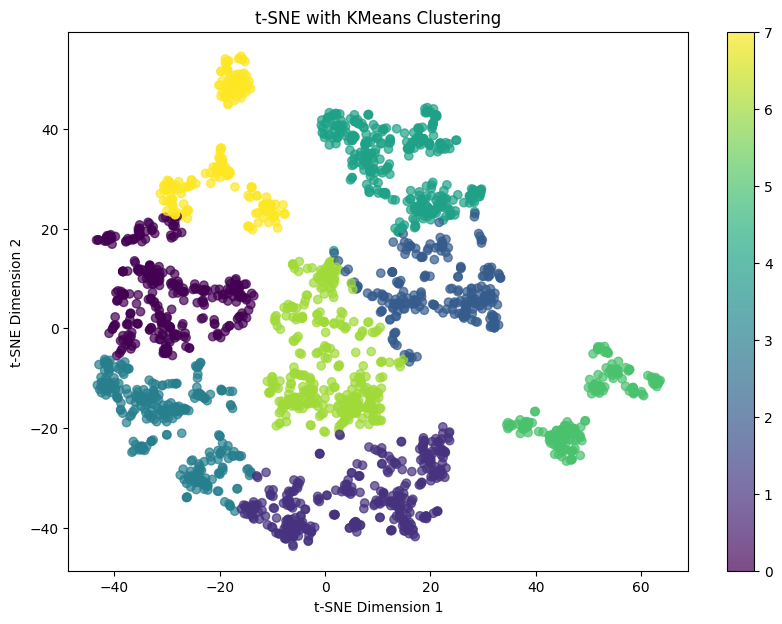

In [ ]:

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

result = np.vstack((unnormalized, unnormalized_cliped))

scaler = StandardScaler()
scaled_data = scaler.fit_transform(result)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(result)

kmeans = KMeans(n_clusters=8, random_state=42) 
kmeans_labels = kmeans.fit_predict(tsne_results)

plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('t-SNE with KMeans Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [ ]:
# import pandas as pd
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans,DBSCAN
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(normalized)
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(normalized)

# kmeans = KMeans(n_clusters=8, random_state=42) 
# kmeans_labels = kmeans.fit_predict(tsne_results)

# plt.figure(figsize=(10, 7))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
# plt.colorbar()
# plt.title('t-SNE with KMeans Clustering')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.show()


In [ ]:
# import pandas as pd
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans,DBSCAN
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(angle)
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(angle)

# kmeans = KMeans(n_clusters=8, random_state=42) 
# kmeans_labels = kmeans.fit_predict(tsne_results)

# plt.figure(figsize=(10, 7))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
# plt.colorbar()
# plt.title('t-SNE with KMeans Clustering')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.show()


In [ ]:
# import pandas as pd
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans,DBSCAN
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(normalized_and_angle)
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(normalized_and_angle)

# kmeans = KMeans(n_clusters=8, random_state=42) 
# kmeans_labels = kmeans.fit_predict(tsne_results)

# plt.figure(figsize=(10, 7))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
# plt.colorbar()
# plt.title('t-SNE with KMeans Clustering')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.show()


In [ ]:
void_bouts = []
for i, group in enumerate(file_matches):
    for entry in group["Pose_Data"][group["Pose_Data"]["Is_Voiding"]]["group"]:
        void_bouts.append((i,entry))

In [ ]:
len(group["Pose_Data"]["Keep"][group["Pose_Data"]["Keep"] == True]) // 300

119

In [ ]:
tone_on = group["Pose_Data"][group["Pose_Data"]["Tone_Start"]]["group"]
tone_off = group["Pose_Data"][group["Pose_Data"]["Tone_End"]]["group"]
clip_start = group["Pose_Data"][group["Pose_Data"]["Clip_Start"]]["group"]

group["Pose_Data"][group["Pose_Data"]["Tone_Start"]]["group"]

import seaborn as sns
data = kmeans_labels
N = len(kmeans_labels) // 8

data = data.reshape(8, N)

plt.figure(figsize=(25, 3))
ax = sns.heatmap(data, cmap="Set1", square=True)

for row, col in void_bouts:
    ax.scatter(col + 0.5, row + 0.5, color='black', s=100, marker='x', zorder=3)

for pos in clip_start:
    ax.axvline(x=pos, ymin=0, ymax=5, color='black', linestyle='-', linewidth=2, zorder=3)

for pos in tone_on:
    ax.axvline(x=pos, ymin=0, ymax=5, color='black', linestyle='--', linewidth=2, zorder=3)

for pos in tone_off:
    ax.axvline(x=pos, ymin=0, ymax=5, color='black', linestyle='--', linewidth=2, zorder=3)

plt.show()

ValueError: cannot reshape array of size 2450 into shape (8,306)

In [ ]:
group["Pose_Data"][group["Pose_Data"]["Tone_End"]]["group"]

2935       9.0
6535      21.0
10135     33.0
13735     45.0
17336     57.0
20936     69.0
24536     81.0
28136     93.0
31735    105.0
35335    117.0
Name: group, dtype: float64

In [ ]:
len(occurrences)

NameError: name 'occurrences' is not defined

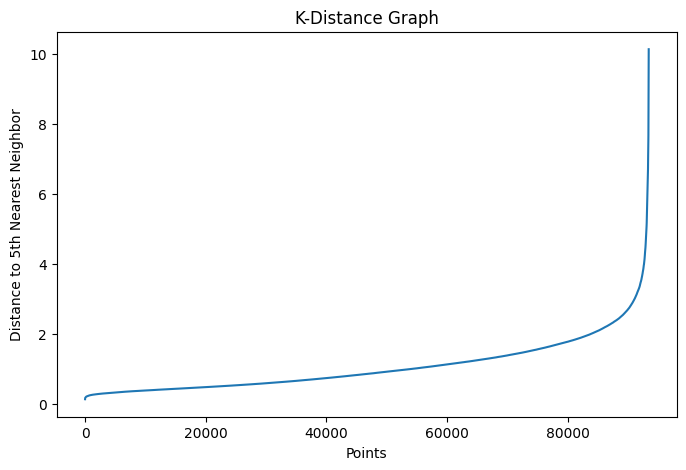

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Assuming df_scaled is your scaled dataset (from earlier steps)
# Step 1: Compute k-nearest neighbors
neigh = NearestNeighbors(n_neighbors=100)  # Choose 5 as a typical value for DBSCAN
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

# Step 2: Sort the distances for the k-th nearest neighbor (in this case, 5th)
distances = np.sort(distances[:, 4])  # The 4th index because k=5

# Step 3: Plot the k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.show()